In [24]:
import json
import numpy as np
import logging
import h5py
from tqdm import tqdm
from constants import *

np.random.seed(0)
logging.basicConfig(
    filename="./logs/log_getdataset.txt",
    filemode='a',
    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
    datefmt='%H:%M:%S',
    level=logging.INFO
)
logger=logging.getLogger() 
logger.setLevel(logging.INFO) 

VERSION = "_rl_final_new2_cate_test4"
FILTER = ""
VERSION = "_reddit"
# FILTER = "_filter"
VERSION = "_realuser"
VERSION = "_40_June"
FILTER = ""

with open(f"{root_path}/dataset/sock_puppets{VERSION}.json", "r") as json_file:
    data = json.load(json_file)[2]["data"]

with open(f"{root_path}/dataset/video_ids{VERSION}.json", "r") as json_file:
    video_ids = json.load(json_file)

with open(f"{root_path}/dataset/category_ids_latest.json", "r") as json_file:
    cate_ids = json.load(json_file)

with open(f"{root_path}/dataset/video_metadata{VERSION}.json", "r") as json_file:
    video_metadata = json.load(json_file)

with open(f"{root_path}/dataset/topic/tag2class{VERSION}2.json", "r") as json_file:
    tag2class = json.load(json_file)

with open(f"{root_path}/dataset/topic/class2id2.json", "r") as json_file:
    class2id = json.load(json_file)


video2class = {}
cnt = 0
cnt_fail = 0
for video_id in video_metadata.keys():
    try:
        tags = video_metadata[video_id]["tags"].split(",")
        classes = {}
        classes_conf = {}
        
        for tag in tags:
            if tag == "":
                continue

            c = tag2class[tag][0]
            conf = tag2class[tag][1]
            if c not in classes.keys():
                classes[c] = 0
                classes_conf[c] = 0
            classes[c] += 1
            classes_conf[c] += conf
        
        video2class[video_id] = []

        for c in classes.keys():
            classes_conf[c] /= classes[c]
            if classes_conf[c] > 0:
                video2class[video_id].append(c)

        cnt += 1
        if cnt < 0:
            print("***************")
            print("Video id: ", video_id)
            print("Tags: ", tags)
            print("Classes: ", classes_conf)
    except:
        cnt_fail += 1
        continue

print(cnt_fail)


def sample_false_label(
    label: list, 
    num_labels: int, 
    max_label_len: int=100
):
    ret = label
    true_label = dict(zip(ret, [0 for _ in range(len(ret))]))
    false_label = list(np.random.randint(num_labels, size=max_label_len + 10 * len(label)))

    idx = 0
    while len(ret) < max_label_len:
        if false_label[idx] in true_label.keys():
            idx +=1 
            continue
        ret.append(false_label[idx])
        idx += 1
    return ret


cnt = 0
missed_videos = {}
input_data_all = []
label_data_all = []
label_type_data_all = []
mask_data_all = []
last_label_all = []
last_label_type_all = []
last_cate_all = []

max_label_len = 1000
max_trail_len = 40
topk_home = 100
last_gain = 1
initial_home_video_ids = {}
popular_home_video_id = {}

for i in tqdm(range(len(data))):
    initial_home_video_ids.update(dict(zip(data[i]["initial_homepage"], [1 for _ in range(len(data[i]["initial_homepage"]))])))
    video_views = data[i]["homepage"]
    tmp = {}
    for video_view in video_views:
        for video_id in video_view:
            if video_id in initial_home_video_ids.keys():
                continue
            if video_id not in popular_home_video_id.keys():
                popular_home_video_id[video_id] = 0
            if video_id not in tmp.keys():
                tmp[video_id] = 1
                popular_home_video_id[video_id] += 1
            else:
                tmp[video_id] = 1
print(len(initial_home_video_ids))

unique_videos = []
for video in popular_home_video_id.keys():
    if popular_home_video_id[video] > 0 and popular_home_video_id[video] < 100:
        unique_videos.append(video)
for video in unique_videos:
    del popular_home_video_id[video]

print(len(popular_home_video_id))

tmp = {}
num_video_missing_cate = 0
for i in range(len(data)):
    # try:
    input_data = []
    mask_data = []

    # Get video trails
    video_views = data[i]["viewed"]
    tmp[str(video_views)] = 1
    tmp_view = []
    for video_id in video_views:
        # if video_id in video_ids.keys():
        input_data.append(video_ids[video_id])
        mask_data.append(1)
        try:
            tmp_view.append(video_metadata[video_id]["categories"])
        except:
            continue

    # Append -1 if the length of trail is smaller than max_trail_len
    if len(input_data) > 41:
        print(len(input_data))
    if len(input_data) < max_trail_len:
        for _ in range(max_trail_len-len(input_data)):
            input_data.append(-1)
            mask_data.append(0)

    # Get recommended video trails
    rec_trails = data[i]["recommendation_trail"]
    label_data = []
    label_type_data = []
    
    for j in range(len(rec_trails)):
        label = []
        label_type = []
        trail = rec_trails[j]

        # # Get all the recommended videos each step
        # for video_id in trail:
        #     label.append(video_ids[video_id])
        #     label_type.append(1)
        
        # Label_type: 0 -> true label, 1 -> false label
        label_type += [0 for _ in range(max_label_len-len(label_type))]

        # Generate false labels
        label = sample_false_label(label, len(class2id.keys()), max_label_len)
        label_data.append(np.array(label))
        label_type_data.append(np.array(label_type))

    # Get homepage recommendation
    home_recs = data[i]["homepage"]

    # In the last step, we want to predict the homepage videos
    last_label = [0 for _ in range(len(class2id))]
    last_cate_dict = {}
    last_label_type = []
    home_video_ids = {}
    for home_rec in home_recs:
        for video_id in home_rec:
            if video_id in initial_home_video_ids.keys():
                continue
            if video_id in popular_home_video_id.keys():
                continue
            if video_id not in home_video_ids.keys():
                home_video_ids[video_id] = 0
            home_video_ids[video_id] += 1
    
    for video_id in list(home_video_ids.keys()):
        try:
            for cate in video2class[video_id]:
                if cate not in last_cate_dict.keys():
                    last_cate_dict[cate] = 0
                last_cate_dict[cate] += 1
        except:
            num_video_missing_cate += 1
            continue

    last_cate_dict = {k : v for k, v in sorted(last_cate_dict.items(), key=lambda item: item[1], reverse=True)}
    
    # if i % 100 == 0:
    #     print(last_cate_dict)

    last_cate_dict = list(last_cate_dict.keys())[:20]
    for cate in last_cate_dict:
        last_label[class2id[cate]] = 1

    # total_f = sum(list(last_cate_dict.values()))
    # for cate in last_cate_dict.keys():
    #     last_label[class2id[cate]] = last_cate_dict[cate] / total_f

    last_label_type = [1 for _ in range(len(last_label))]

    input_data_all.append(np.array(input_data))
    label_data_all.append(np.array(label_data))
    label_type_data_all.append(np.array(label_type_data))
    mask_data_all.append(np.array(mask_data))
    last_label_all.append(np.array(last_label))
    last_label_type_all.append(np.array(last_label_type))

    # except:
    #     cnt += 1
    
logger.info("Missing {} trails.".format(cnt))

idx = [i for i in range(len(input_data_all))]
np.random.seed(0)
np.random.shuffle(idx)
print(len(tmp), num_video_missing_cate)

train_size = int(len(idx) * 0.8)
input_data_all = np.stack(input_data_all)
label_data_all = np.stack(label_data_all)
mask_data_all = np.stack(mask_data_all)
label_type_data_all = np.stack(label_type_data_all)
last_label_all = np.stack(last_label_all)
last_label_type_all = np.stack(last_label_type_all)

class_weight = np.clip(last_label_all.sum(0) / len(idx), 0.1, 0.9)
class_weight = (1 - class_weight).tolist()

with open(f"{root_path}/dataset/topic/class_weight.json", "w") as json_file:
    json.dump({"w": class_weight}, json_file)

logger.info("Input: {}, label: {}, label_type: {}, mask: {}, last_label: {}, last_label_type: {}.".format(
    np.shape(input_data_all), 
    np.shape(label_data_all), 
    np.shape(label_type_data_all), 
    np.shape(mask_data_all),
    np.shape(last_label_all),
    np.shape(last_label_type_all))
)



  2%|▏         | 200/9630 [00:00<00:04, 1994.39it/s]

4161


100%|██████████| 9630/9630 [00:04<00:00, 2402.57it/s]


7875
3544
9630 6575


In [25]:
print(last_label_all.shape)

def kl_divergence(p, q):
	return sum([p[i] * np.log2((p[i] + 1e-7)/(q[i] + 1e-7)) for i in range(len(p))])

avg_kl_all = []
for p in tqdm(last_label_all[0:100]):
    avg_kl = []
    avg_kl_all.append(kl_divergence(p, np.mean(last_label_all,axis=0)))
    # for q in last_label_all:
    #     avg_kl.append(kl_divergence(p,q))
    # avg_kl = np.mean(avg_kl)
    # avg_kl_all.append(avg_kl)

print(f"Avg kl between two random dis. :{np.mean(avg_kl_all)}")

100%|██████████| 100/100 [00:00<00:00, 580.32it/s]

(9630, 154)
Avg kl between two random dis. :29.968571357393067


[[1.00000000e+00 1.35015828e-02 1.35324991e-02 ... 5.66459072e-03
  2.06617011e-02 4.31820138e-03]
 [3.10487214e-02 1.00000000e+00 7.77140015e-01 ... 1.20219408e-02
  1.32590972e-01 6.19420164e-03]
 [2.00044425e-02 4.99561178e-01 1.00000000e+00 ... 7.29522453e-03
  8.77643174e-02 6.62633032e-03]
 ...
 [1.47630399e-01 1.36245701e-01 1.28616734e-01 ... 1.00000000e+00
  1.35393590e-01 3.88773917e-01]
 [6.18914364e-02 1.72710764e-01 1.77841872e-01 ... 1.55616389e-02
  1.00000000e+00 7.97052410e-03]
 [8.60477691e-06 5.36738844e-06 8.93226007e-06 ... 2.97253232e-05
  5.30223675e-06 1.00000000e+00]]


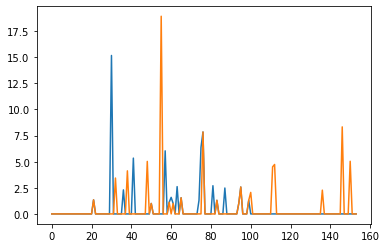

In [26]:
import matplotlib.pyplot as plt
last_label_all_ = last_label_all / (last_label_all.mean(0) + 1e-7)
for i in range(2):
    plt.plot(last_label_all_[i+6][:])

print(last_label_all_ @ last_label_all_.transpose() / (np.linalg.norm(last_label_all_, axis=-1) ** 2).reshape(-1,1))

In [27]:
hf = h5py.File(f"{root_path}/dataset/train_data{VERSION}{FILTER}.hdf5", "w")
hf.create_dataset('input', data=input_data_all[idx[:train_size]])
hf.create_dataset('label', data=label_data_all[idx[:train_size]])
hf.create_dataset('label_type', data=label_type_data_all[idx[:train_size]])
hf.create_dataset('last_label', data=last_label_all[idx[:train_size]])
hf.create_dataset('last_label_type', data=last_label_type_all[idx[:train_size]])
hf.create_dataset('mask', data=mask_data_all[idx[:train_size]])
hf.close()

hf = h5py.File(f"{root_path}/dataset/test_data{VERSION}{FILTER}.hdf5", "w")
hf.create_dataset('input', data=input_data_all[idx[train_size:]])
hf.create_dataset('label', data=label_data_all[idx[train_size:]])
hf.create_dataset('label_type', data=label_type_data_all[idx[train_size:]])
hf.create_dataset('last_label', data=last_label_all[idx[train_size:]])
hf.create_dataset('last_label_type', data=last_label_type_all[idx[train_size:]])
hf.create_dataset('mask', data=mask_data_all[idx[train_size:]])
hf.close()

home_video_id = {}
for i in range(train_size):
    for j in range(sum(last_label_type_all[i])):
        video_id = str(last_label_all[i][j])
        if video_id not in home_video_id.keys():
            home_video_id[video_id] = 0
        home_video_id[video_id] += 1

home_video_id_sorted = {k: v for k, v in sorted(home_video_id.items(), key=lambda item: item[1], reverse=True)}
with open(f"{root_path}/dataset/home_video_id_sorted{VERSION}{FILTER}.json", "w") as json_file:
    json.dump(home_video_id_sorted, json_file)
